<a href="https://colab.research.google.com/github/MuhammadAriefTI20/Deep-Learning/blob/main/rokok_sampoerna_splash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download masarief/rokok-sampoerna-splash
!mkdir dataset
!unzip /content/rokok-sampoerna-splash.zip -d /content/dataset

In [45]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import Adam
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split

In [46]:
dataset_path = Path(r'/content/dataset')
file_path = list(dataset_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

In [47]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)
df = pd.concat([file_path, labels], axis=1)
df.columns = ['image', 'label']
df.head()

,image,label
0,/content/dataset/tropical/tropical (20).jpg,tropical
1,/content/dataset/tropical/tropical (37).jpg,tropical
2,/content/dataset/tropical/tropical (61).jpg,tropical
3,/content/dataset/tropical/tropical (68).jpg,tropical
4,/content/dataset/tropical/tropical (27).jpg,tropical


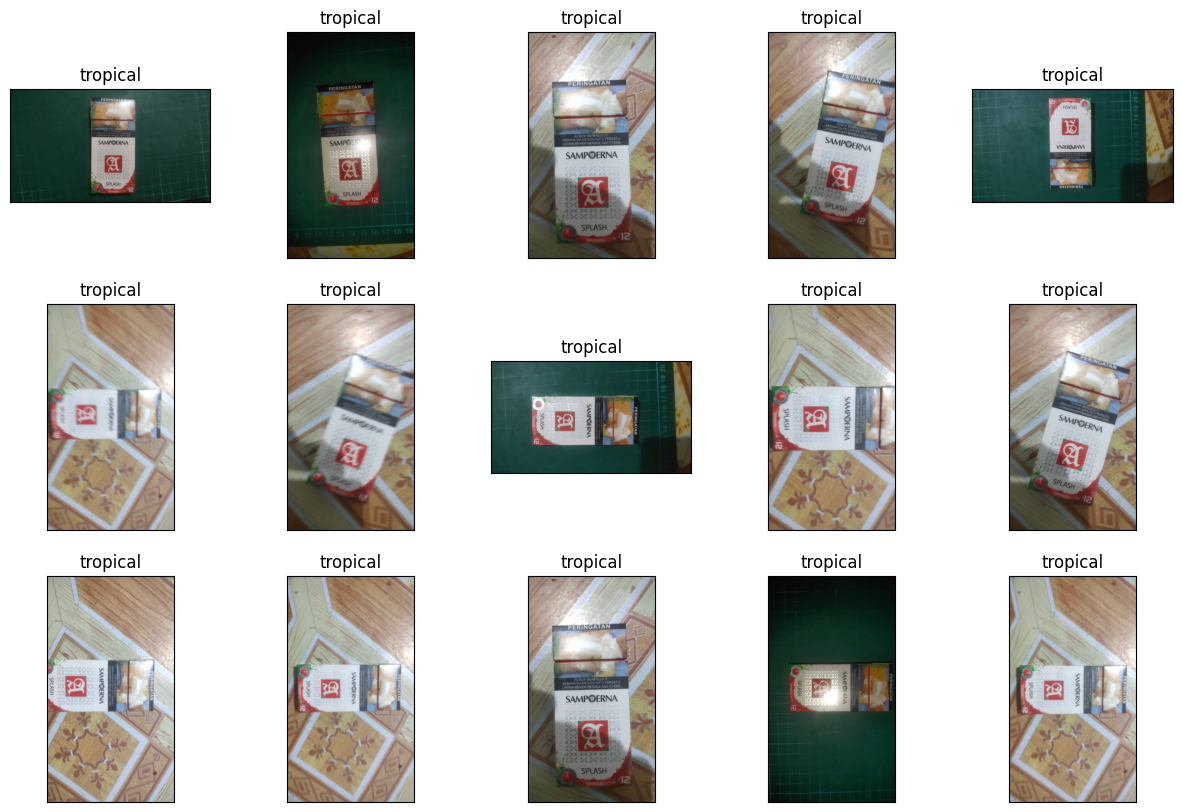

In [48]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.image[i]))
    ax.set_title(df.label[i])
    
plt.show()

In [49]:
df.label.value_counts()

tropical    106
sunny       106
spring      106
Name: label, dtype: int64

In [50]:
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)
df.label.value_counts()

tropical    106
sunny       106
spring      106
Name: label, dtype: int64

In [51]:
x_train, x_test = train_test_split(df, test_size=0.3,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [52]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (177, 2)
Shape of test data (96, 2)
Shape of validation data (45, 2)


In [53]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)

Found 177 validated image filenames belonging to 3 classes.
Found 96 validated image filenames belonging to 3 classes.
Found 45 validated image filenames belonging to 3 classes.


In [54]:
input_shape = (200, 200, 3)

In [55]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 99, 99, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 23, 23, 32)      

In [64]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history = model.fit(train, batch_size= 512, validation_data=val, epochs=100, callbacks=callback)

Epoch 1/100
6/6 [==============================] - 13s 2s/step - loss: 0.6916 - accuracy: 0.7062 - val_loss: 0.4628 - val_accuracy: 0.8444
Epoch 2/100
6/6 [==============================] - 8s 1s/step - loss: 0.5728 - accuracy: 0.7853 - val_loss: 0.2922 - val_accuracy: 0.8889
Epoch 3/100
6/6 [==============================] - 10s 2s/step - loss: 0.4693 - accuracy: 0.8475 - val_loss: 0.4236 - val_accuracy: 0.8667
Epoch 4/100
6/6 [==============================] - 9s 2s/step - loss: 0.3866 - accuracy: 0.8644 - val_loss: 0.4268 - val_accuracy: 0.8444
Epoch 5/100
6/6 [==============================] - 9s 2s/step - loss: 0.3856 - accuracy: 0.8531 - val_loss: 0.3696 - val_accuracy: 0.8667
Epoch 6/100
6/6 [==============================] - 8s 1s/step - loss: 0.3304 - accuracy: 0.8701 - val_loss: 0.3158 - val_accuracy: 0.8667
Epoch 7/100
6/6 [==============================] - 9s 1s/step - loss: 0.3858 - accuracy: 0.8475 - val_loss: 0.3417 - val_accuracy: 0.8444
Epoch 8/100
6/6 [===============

In [65]:
model.save('model-1.h5')

In [66]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

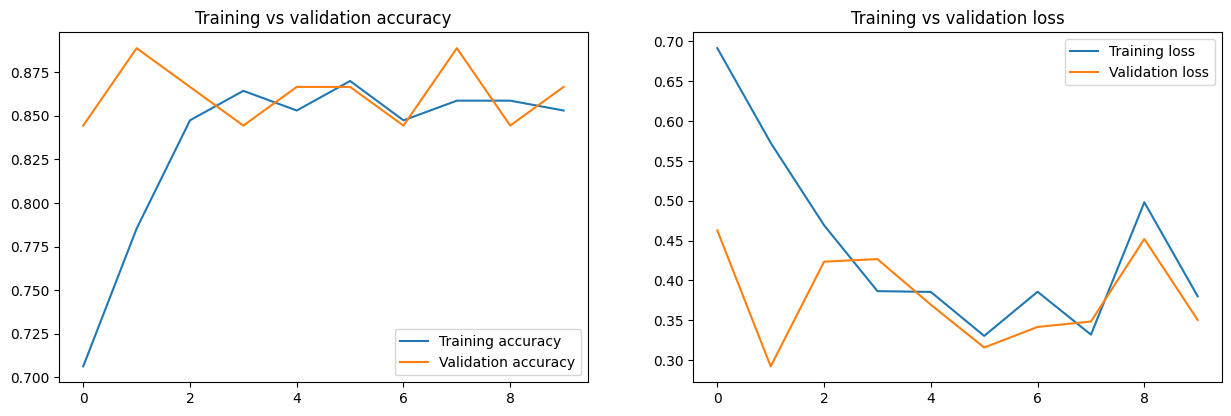

In [104]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")
plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")
plt.show()

In [108]:
pred = model.predict(test)

3/3 [==============================] - 4s 1s/step


In [109]:
pred = np.argmax(pred, axis=1)

In [110]:
labels = train.class_indices

In [111]:
labels

{'spring': 0, 'sunny': 1, 'tropical': 2}

In [112]:
labels = dict((v,k) for k, v in labels.items())

In [113]:
labels

{0: 'spring', 1: 'sunny', 2: 'tropical'}

In [114]:
y_pred = [labels[k] for k in pred]

In [115]:
print(classification_report(x_test.label, y_pred))

              precision    recall  f1-score   support

      spring       0.96      0.89      0.92        27
       sunny       0.94      0.89      0.91        36
    tropical       0.84      0.94      0.89        33

    accuracy                           0.91        96
   macro avg       0.91      0.91      0.91        96
weighted avg       0.91      0.91      0.91        96



In [116]:
print(confusion_matrix(x_test.label, y_pred))

[[24  1  2]
 [ 0 32  4]
 [ 1  1 31]]


In [117]:
test_accuracy = model.evaluate(test)[1]

3/3 [==============================] - 4s 1s/step - loss: 0.3348 - accuracy: 0.8750
